In [394]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from scipy.special import factorial
import sympy as sp
import scipy as sc
from scipy.optimize import minimize_scalar


In [930]:
class Performative_Regression:

    def __init__(self, k, n , T, sigma=1, M=1):
        """
        Parameters:
        - k (int): Polynomial degree.
        - n (int): Number of samples for each theta_i.
        - T (float): Total number of rounds, should be > kn.
        - sigma (float, optional): Standard deviation of the noise. Default is 1.
        - M (float, optional): Bound of the derivatives of f. Default is 1.
        """
        self.k = k
        self.n = n
        self.T = T
        self.sigma = sigma
        self.M = M
        self.z = 1.96

        # Produce k+1 Chebyshev nodes
        self.thetas = np.cos(np.pi * (2*np.arange(1, self.k+2) - 1 ) / (2*(self.k + 1)))

        # 
        #self.thetas = np.cos(np.pi * (2*np.arange(self.k+1) + 1 ) / (2*self.k + 2)) / np.cos(np.pi / (2*self.k + 2))
        


        self.f_hat_values = self.f_hat()


        
               
    def f(self, theta):
        """
        Computes the true function value at a given Chebyshev node.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The function value at the specified theta.
        """

        
        fun = theta + theta**2 
        fun = np.sin(theta)
        return fun
  
    def f_hat(self):
        """
        Generates the array of noisy function values at the Chebyshev nodes.

        Returns:
        - numpy.ndarray: Array with element i equal to f_hat(theta_i) where theta_i is the ith Chebyshev node.
        """
        
        Y = (
            np.repeat(self.f(self.thetas)[:, np.newaxis], self.n, axis=1) +
            np.random.normal(0, self.sigma, (self.k+1, self.n))
        )

        f_hat = np.mean(Y, axis=1)

        return f_hat

    def vandermonde_matrix(self, nodes):
        """
        Computes the Vandermonde matrix with Chebyshev nodes.

        Returns:
        - numpy.ndarray: The Vandermonde matrix.
        """

        return np.vander(nodes, increasing=True)

    def vandermonde_determinant(self):
        """
        Computes the determinant of the Vandermonde matrix.

        Returns:
        - float: The determinant of the Vandermonde matrix.
        """

        det = (-1)**((self.k+1) * self.k / 2 ) * ((self.k+1)**(self.k+1) / 2**(self.k*self.k))**(1/2)
        
        return det   
    
    def true_loss(self, theta):
        """
        Computes the true objective function at a given Chebyshev node.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The true objective function evaluated at theta.
        """

        return self.f(theta)**2 - 2 * theta * self.f(theta) + theta**2
    
    def g_hat(self, theta):

        """
        Computes the estimated g_hat at a given theta.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The estimated function value at the specified theta.
        """
        p_theta = 0
        for i in range(self.k+1):
            prod = 1
            for j in range(self.k+1):
                if j != i:
                    prod = prod * (theta - self.thetas[j]) / (self.thetas[i] - self.thetas[j])

            p_theta = p_theta + prod * self.f_hat_values[i]
        
        return p_theta
    
    def bayes_estimate(self):

        V = self.vandermonde_matrix()
        S2 = np.eye(self.k+1) @ np.array([i for i in range(1, self.k+2)])
        S = np.linalg.inv(S2 + V.T @ V / self.sigma)

        mu = 1 / self.sigma * S @ V.T @ self.f_hat_values 

        return mu
    
    def approxim(self, theta):

        vec = np.array([theta**i for i in range(self.k+1)])

        return vec @ self.bayes_estimate()

    def estimated_loss(self, theta):
        """
        Computes the estimated objective function value at a given theta.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The estimated objective function value at the specified theta.
        """

        g_estimate = self.g_hat(theta)

        return g_estimate**2 - 2 * theta * g_estimate + theta**2

    def optimistic_loss(self, theta):

        ci = self.conf_interval_at_theta(theta)

        g_values = np.linspace(self.g_hat(theta) - ci, self.g_hat(theta) + ci, 1000)

        return np.min(g_values**2 - 2 * theta * g_values + theta**2, axis=0)
    
    def pessimistic_loss(self, theta):

        ci = self.conf_interval_at_theta(theta)

        g_values = np.linspace(self.g_hat(theta) - ci, self.g_hat(theta) + ci, 1000)

        return np.max(g_values**2 - 2 * theta * g_values + theta**2, axis=0)

    def remainder(self, theta):
        """
        Computes the upper bound of the absolute value of the remainder term for a given theta.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The upper bound of the absolute value of the remainder term at the specified theta.
        """

        cheb_polynomial = np.cos((self.k+1)*np.arccos(theta))/(2**(self.k))

        return self.M * np.abs(cheb_polynomial) / math.factorial(self.k + 1)

    def lagrange_bound(self, theta):

        sum_new = 0
        for i in range(self.k+1):
            sum_new += np.abs(
                (-1)**i * np.sin(np.pi * (2*i + 1) / (2*self.k + 2)) * np.cos((self.k+1)*np.arccos(theta)) / (self.k+1) / (theta - np.cos(np.pi * (2*i + 1) / (2*self.k + 2)))
            )  

        #return np.sqrt(2 - 1 / (self.k + 1))
        return sum_new
       
    def conf_interval_at_theta(self, theta):

        """
        Computes the confidence interval at a theta.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The confidence interval at the specified theta.
        """
        B_1 = self.remainder(theta)
        B_2 = self.lagrange_bound(theta) * self.z * self.sigma / np.sqrt(self.n)
        
        return B_1 + B_2

    def bayes_ci(self, theta):
        lagrange_squared_sum = 0

        for i in range(self.k+1):

            lagrange_square = 1
            for j in range(self.k+1):
                if j != i:
                    lagrange_square = lagrange_square * (theta - self.thetas[j]) / (self.thetas[i] - self.thetas[j])

            lagrange_squared_sum += lagrange_square**2

        return lagrange_squared_sum * self.sigma**2
        #return self.z * self.sigma * np.sqrt(2 - 1 / (self.k + 1)) / np.sqrt(self.n)
        return self.z * self.sigma * np.sqrt(lagrange_squared_sum) / np.sqrt(self.n)

    def R(self, theta):

        prod = 1 
        for i in range(self.k+1):
            prod = prod * (theta - self.thetas[i])

        #return prod
        #return self.M / 2**self.k / math.factorial(self.k+1)
        return np.abs(prod * self.M / math.factorial(self.k+1))
    
    def minimum(self):

        t = np.linspace(-1, 1, 10000)
        gs = self.estimated_loss(t)
        fs = self.true_loss(t)
        estimated_min = t[np.argmin(gs)]
        true_min = t[np.argmin(fs)]
        return estimated_min, true_min

    def plot_f_vs_g(self):
        
        t = np.linspace(-1, 1, 1000)
        
        plt.plot(t, self.f(t), 'k--', label=r'$f(\theta)$')
        plt.plot(t, self.g_hat(t), 'C1--', label=r"$\hat{g}(\theta)$")
        
        #plt.plot(t, self.g_hat(t) - self.R(t) - self.bayes_ci(t), 'k--')
        #plt.plot(t, self.g_hat(t) + self.R(t) + self.bayes_ci(t), 'k--', label="Confidence interval")
        plt.fill_between(t, self.g_hat(t) - self.bayes_ci(t) , self.g_hat(t) + self.bayes_ci(t) , alpha=0.3, color='C1', label="my method")
        
    def plot_objectives(self):
        
        t = np.linspace(-1, 1, 1000)
        plt.plot(t, self.true_loss(t), 'C1', label='true objective')
        plt.plot(t, self.estimated_loss(t), 'C1--', label=f'estimated loss for k={self.k}')
        plt.fill_between(t,
                         self.optimistic_loss(t),
                         self.pessimistic_loss(t),
                         alpha=0.3,
                         color='C1')

        estimated_min = self.minimum()[0]
        true_min = self.minimum()[1]
        plt.scatter(true_min, self.true_loss(true_min), label=r'$\theta_{PO}$', color='k')
        plt.scatter(estimated_min, self.true_loss(estimated_min), label=r'$\hat{\theta}_{PO}$', marker='x', color='r')
        plt.xlabel(r"$\theta$")


In [1004]:
def polynomial_kernel(x, y, degree, alpha=2):

    result = 0
    for i in range(degree+1):
        result += math.comb(degree, i) * (np.dot(x, y)) ** i

    #return (np.dot(x, y)+1)**degree
    return result

def sig(x_new, X):
    # Compute the kernel matrix
    
    K = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            K[i, j] = polynomial_kernel(X[i], X[j], degree=X.shape[0]-1)

    # Add a small constant to the diagonal for numerical stability
    #K += 1e-6 * np.eye(K.shape[0])

    # Compute the kernel vector for the new point
    k = np.array([polynomial_kernel(x_new, X[i], degree=X.shape[0]-1) for i in range(X.shape[0])])

    # Compute the covariance matrix for the new point
    K_inv = np.linalg.inv(K + 0**2*np.eye(X.shape[0]))
    cov_new = polynomial_kernel(x_new, x_new, degree=X.shape[0]-1) - np.dot(k.T, np.dot(K_inv, k))

    # Calculate the mean and standard deviation for the new point
    std_dev_new = np.sqrt(cov_new)
    
    mean_new = k.T @ (K_inv) @ y

    return mean_new, std_dev_new




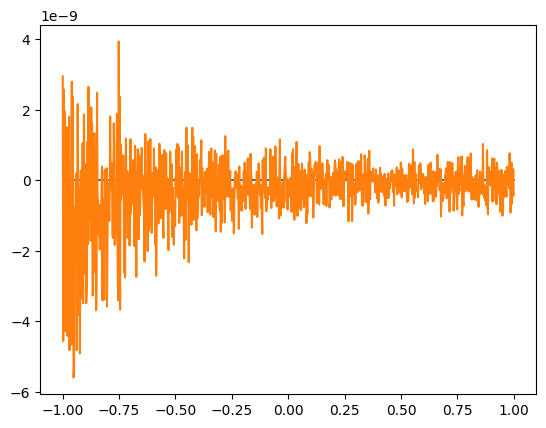

In [1002]:
sigma=0
pr = Performative_Regression(k=10, n=1, T=1, sigma=sigma, M=1)
V = pr.vandermonde_matrix(np.random.uniform(-1, 1, size=11))
M = V @ V.T
M_inv = np.linalg.inv(M)
def f(sigma, x):
    s = sigma
    x = np.array([x**i for i in range(len(pr.thetas))])
    
    A = s**2 * x.T @  V.T @ V @ x
    B = x.T @ x - x.T @ V.T @ np.linalg.inv(M + sigma**2 * np.eye(len(pr.thetas))) @ V @ x
    
    return A, B


t = np.linspace(-1, 1, 1000)
a = np.array([f(sigma, i)[0] for i in t])
b = np.array([f(sigma, i)[1] for i in t])
#plt.plot(t, a)
plt.plot(t, pr.bayes_ci(t))
plt.plot(t, b)
plt.show()

C:\Users\Ivan\AppData\Local\Temp\ipykernel_2096\3285928476.py:29: RuntimeWarning: invalid value encountered in sqrt
  std_dev_new = np.sqrt(cov_new)


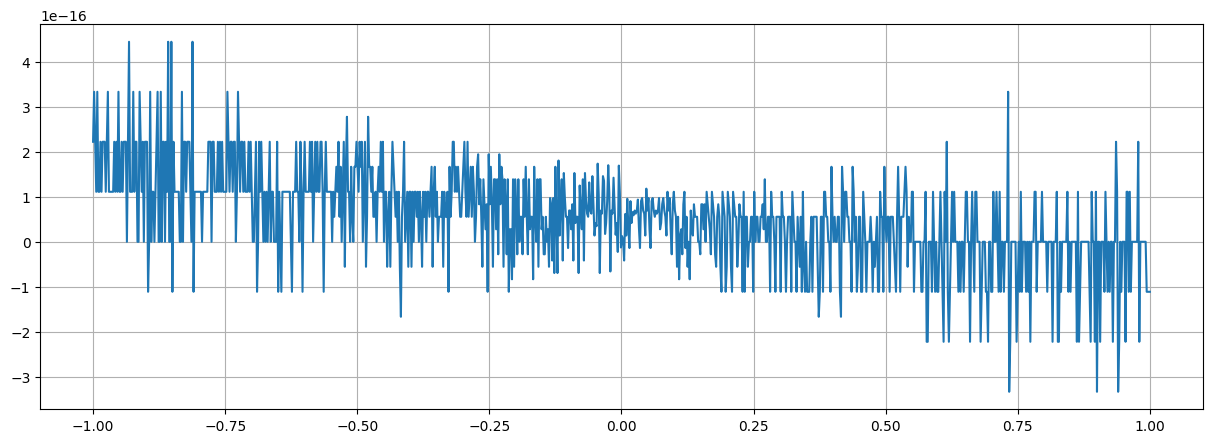

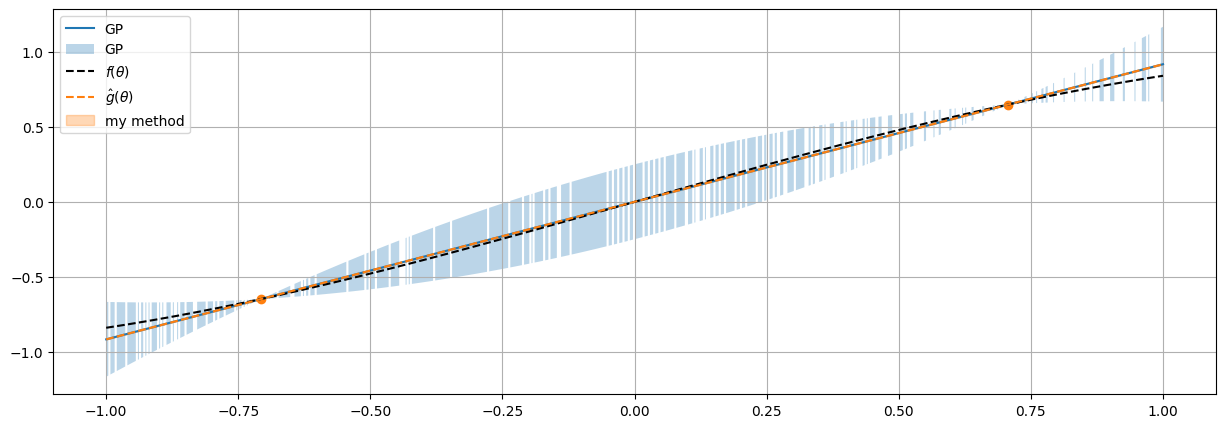

In [1007]:
k = 1
pr = Performative_Regression(k=k, n=1, T=1, sigma=0, M=1)
M = 1
X = pr.thetas
X = X.reshape(-1, 1)
y = pr.f_hat_values
t = np.linspace(-1, 1, 1000)

def remainder(x):
    xs = 1
    for i in range(X.shape[0]):
        xs = xs * np.abs(x - X[i][0])

    return xs

stds = np.array([sig(i, X)[1] for i in t]).reshape(1000, )
means = np.array([sig(i, X)[0] for i in t]).reshape(1000, )
plt.figure(figsize=(15, 5))
plt.plot(t, means - pr.g_hat(t))
plt.grid()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(t, means, label="GP")
plt.fill_between(t, means-1.96*stds - pr.R(t) , means + 1.96*stds +pr.R(t), alpha=0.3, label="GP")
plt.scatter(pr.thetas, pr.f_hat_values)
pr.plot_f_vs_g()
plt.legend()
plt.grid()
plt.show()